# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

In [1129]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/svetlanamaslennikova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1130]:
data = pd.read_csv('train.csv')

In [1131]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [1132]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

пропуски в train

In [1133]:
na = train.isnull().any().values

for c in train.columns[na]:
    print('Пропусков в столбце {}: {}'.format(c, np.sum(train[c].isnull())))

Пропусков в столбце keyword: 44
Пропусков в столбце location: 1760


In [1134]:
train = train.fillna('')
train.isnull().any().any()

False

пропусти в test

In [1135]:
na = test.isnull().any().values

for c in test.columns[na]:
    print('Пропусков в столбце {}: {}'.format(c, np.sum(test[c].isnull())))

Пропусков в столбце keyword: 17
Пропусков в столбце location: 773


In [1136]:
test = test.fillna('')
test.isnull().any().any()

False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

распределение классов

0    56.746106
1    43.253894
Name: target, dtype: float64

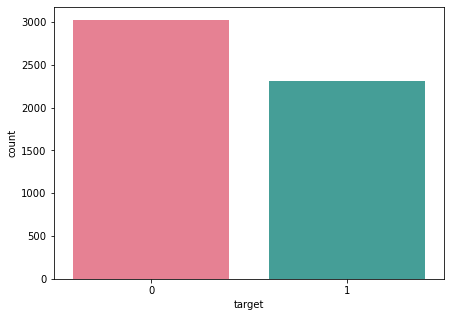

In [1137]:
plt.figure(figsize = (7, 5))
sns.countplot(x = 'target',   data = train, palette = 'husl')
train['target'].value_counts(normalize=True) * 100

Классы распределены более-менее равномерно, класс 0 занимает 56,74% обучающей выборки, класс 1 - 43,25%, сильного перекоса в какой-то из классов нет

гугл сказал что ступенчатая диаграмма распределения это гистограмма распределения так что вот 

In [1138]:
mask = pd.DataFrame(train[train['keyword'] != '']['keyword'].value_counts()[:10])
mask = mask.reset_index()
train_fr_keywords = pd.merge(train, mask, left_on = 'keyword', right_on='index')

<AxesSubplot:xlabel='keyword_x', ylabel='count'>

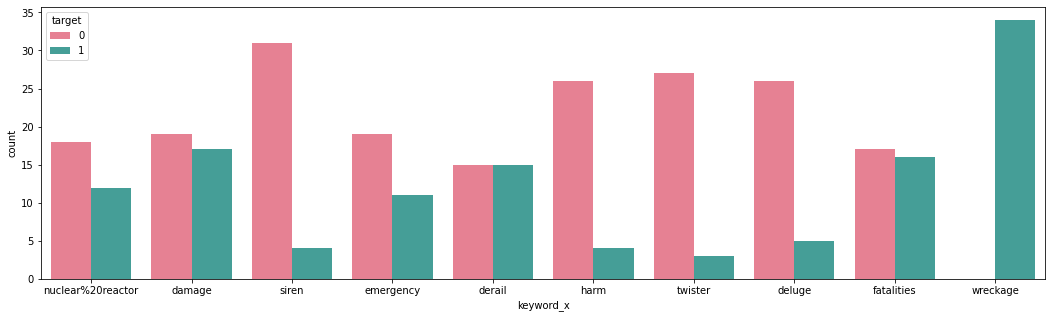

In [1139]:
plt.figure(figsize = (18, 5))
sns.countplot(x = 'keyword_x', hue = 'target',  data = train_fr_keywords, palette = 'husl')

Забавно что со словом damage, fatalities и derail почти поровну позитивных и негативных твитов, a на wreckage все позитивные (????)

по остальным понятна негативная конатация 

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [1140]:
train['text'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']
train = train.drop(columns=['keyword', 'location'])
train

,id,text,target
1186,1707,bridge%20collapse Ashes 2015: AustraliaÛªs c...,0
4071,5789,"hail Carol Stream, Illinois GREAT MICHIGAN TEC...",1
5461,7789,police Houston CNN: Tennessee movie theater s...,1
5787,8257,rioting Still rioting in a couple of hours le...,1
7445,10656,wounds Lake Highlands Crack in the path where ...,0
...,...,...,...
5226,7470,obliteration Merica! @Eganator2000 There aren'...,0
5390,7691,panic just had a panic attack bc I don't have...,0
860,1242,blood Omron HEM-712C Automatic Blood Pressure...,0
7603,10862,Officials say a quarantine is in place at an...,1


In [1141]:
train = train.set_index('id')

In [1142]:
test['text'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']
test = test.drop(columns=['keyword', 'location'])
test

,id,text,target
2644,3796,destruction So you have a new weapon that can...,1
2227,3185,deluge The f$&amp;@ing things I do for #GISHW...,0
5448,7769,police UK DT @georgegalloway: RT @Galloway4May...,1
132,191,aftershock Aftershock back to school kick off...,0
6845,9810,"trauma Montgomery County, MD in response to tr...",0
...,...,...,...
4307,6115,"hellfire 570 Vanderbilt; Brooklyn, NY New cock...",0
3375,4833,evacuation USA Bend Post Office roofers cut ga...,1
1710,2466,collided Monsoon flooding - Monsoon rains hav...,1
4898,6973,massacre Ireland Remember this was a massacre ...,1


In [1143]:
test = test.set_index('id')

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [1144]:
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['text'])

In [1145]:
X.toarray().shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [1146]:
cnt_vec.vocabulary_

{'bridge': 2948,
 '20collapse': 320,
 'ashes': 1928,
 '2015': 295,
 'australia': 2059,
 'ûªs': 18425,
 'collapse': 3914,
 'at': 1977,
 'trent': 16483,
 'among': 1628,
 'worst': 17813,
 'in': 8314,
 'history': 7773,
 'england': 5722,
 'bundled': 3085,
 'out': 11995,
 'for': 6503,
 '60': 755,
 'http': 7970,
 'co': 3861,
 't5trhjuau0': 15733,
 'hail': 7420,
 'carol': 3363,
 'stream': 15419,
 'illinois': 8249,
 'great': 7206,
 'michigan': 10594,
 'technique': 15888,
 'camp': 3261,
 'b1g': 2147,
 'thanks': 16013,
 'to': 16272,
 'bmurph1019': 2753,
 'hail_youtsey': 7421,
 'termn8r13': 15949,
 'goblue': 7088,
 'wrestleon': 17848,
 'oaskgki6qj': 11648,
 'police': 12634,
 'houston': 7933,
 'cnn': 3854,
 'tennessee': 15932,
 'movie': 10940,
 'theater': 16025,
 'shooting': 14647,
 'suspect': 15632,
 'killed': 9246,
 'by': 3150,
 'di8elzswnr': 4890,
 'rioting': 13800,
 'still': 15357,
 'couple': 4204,
 'of': 11708,
 'hours': 7925,
 'left': 9644,
 'until': 16884,
 'have': 7546,
 'be': 2383,
 'up': 

In [1147]:
vocabulary = cnt_vec.vocabulary_

In [1148]:
def dict_analyse(dict):
    vocabulary_keys = list(vocabulary.keys())
    numbers = 0
    punct = 0
    hashtag = 0
    mention = 0
    reg_num = r'\d+'
    reg_punct = '[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    reg_hashtag = '^#\w+'
    reg_mention = '^@\w+'

    for i in range(len(vocabulary_keys)):
        if re.findall(reg_num, vocabulary_keys[i]) != []:
            numbers += 1
        if re.findall(reg_punct, vocabulary_keys[i]) != []:
            punct += 1
        if re.findall(reg_hashtag, vocabulary_keys[i]) != []:
            hashtag += 1
        if re.findall(reg_mention, vocabulary_keys[i]) != []:
            mention += 1
    return f'количество слов с числами: {numbers}, количество слов с пунктуацией: {punct}, количество слов с хэштэгом: {hashtag}, количество слов с упоминанием: {mention}'
     

In [1149]:
dict_analyse(vocabulary)

'количество слов с числами: 3812, количество слов с пунктуацией: 315, количество слов с хэштэгом: 0, количество слов с упоминанием: 0'

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [2]:
from nltk.tokenize import TweetTokenizer
def tokenizer_tw(text):
    tw_tok = TweetTokenizer()
    return tw_tok.tokenize(text)

In [1151]:
cnt_vec_tw = CountVectorizer(tokenizer = tokenizer_tw)
X_t = cnt_vec_tw.fit_transform(train['text'])

In [1152]:
vocabulary = cnt_vec_tw.vocabulary_
dict_analyse(vocabulary)

'количество слов с числами: 3939, количество слов с пунктуацией: 7337, количество слов с хэштэгом: 1468, количество слов с упоминанием: 1678'

TweetTokenizer гораздо более "нежный" токенайзер, он не чистит пунтуацию и сохраняет специфичные для твиттера лингвистические конструкты как токены

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [17]:
from nltk import word_tokenize

In [23]:
stemmer = SnowballStemmer('english')
text = "In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.\n\"Whenever you feel like criticizing any one,\" he told me, \"just remember that all the people in this world haven't had the advantages that you've had.\""
text_tokenized = [stemmer.stem(w) for w in word_tokenize(text) if w.isalpha()]
print(text_tokenized)

['in', 'my', 'younger', 'and', 'more', 'vulner', 'year', 'my', 'father', 'gave', 'me', 'some', 'advic', 'that', 'i', 'been', 'turn', 'over', 'in', 'my', 'mind', 'ever', 'sinc', 'whenev', 'you', 'feel', 'like', 'critic', 'ani', 'one', 'he', 'told', 'me', 'just', 'rememb', 'that', 'all', 'the', 'peopl', 'in', 'this', 'world', 'have', 'had', 'the', 'advantag', 'that', 'you', 'had']


In [22]:
stemmer = SnowballStemmer('english')
text = "In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.\n\"Whenever you feel like criticizing any one,\" he told me, \"just remember that all the people in this world haven't had the advantages that you've had.\""
text_tokenized = [w for w in word_tokenize(text) if w.isalpha()]
text_stemmed = [stemmer.stem(w) for w in text_tokenized]
print(text_stemmed)

['in', 'my', 'younger', 'and', 'more', 'vulner', 'year', 'my', 'father', 'gave', 'me', 'some', 'advic', 'that', 'i', 'been', 'turn', 'over', 'in', 'my', 'mind', 'ever', 'sinc', 'whenev', 'you', 'feel', 'like', 'critic', 'ani', 'one', 'he', 'told', 'me', 'just', 'rememb', 'that', 'all', 'the', 'peopl', 'in', 'this', 'world', 'have', 'had', 'the', 'advantag', 'that', 'you', 'had']


In [1153]:
def custom_tokenizer(text):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')
    tw = TweetTokenizer()
    text_preprocessed = [stemmer.stem(w) for w in tw.tokenize(text.lower()) if (w.isalpha() 
    or re.findall('^#+[a-z]+$', w) != []
    or (re.findall('[a-z0-9]', w) == [] and re.findall('\W+[()]+', w) != [])
    ) and w not in stop_words]
     
    
    return text_preprocessed

In [1154]:
[custom_tokenizer(t) for t in train['text'][:10]]

[['bridg',
  'ash',
  'australia',
  'ûªs',
  'collaps',
  'trent',
  'bridg',
  'among',
  'worst',
  'histori',
  'england',
  'bundl',
  'australia'],
 ['hail',
  'carol',
  'stream',
  'illinoi',
  'great',
  'michigan',
  'techniqu',
  'camp',
  'thank',
  '#goblu',
  '#wrestleon'],
 ['polic',
  'houston',
  'cnn',
  'tennesse',
  'movi',
  'theater',
  'shoot',
  'suspect',
  'kill',
  'polic'],
 ['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class'],
 ['wound',
  'lake',
  'highland',
  'crack',
  'path',
  'wipe',
  'morn',
  'beach',
  'run',
  'surfac',
  'wound',
  'left',
  'elbow',
  'right',
  'knee'],
 ['airplan',
  'somewher',
  'expert',
  'franc',
  'begin',
  'examin',
  'airplan',
  'debri',
  'found',
  'reunion',
  'island',
  'french',
  'air',
  'accid',
  'expert',
  '#mlb'],
 ['bloodi',
  'isol',
  'citi',
  'world',
  'perth',
  'came',
  'kill',
  'indian',
  'fun',
  'video',
  'smirk',
  'remorseless',
  'pakistani',
  'killer',
  'show',
  'boast'],


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [1155]:
cnt_vec_new = CountVectorizer(tokenizer = custom_tokenizer)
X_train = cnt_vec_new.fit_transform(train['text'])
X_test = cnt_vec_new.transform(test['text'])
X_train

<5329x10584 sparse matrix of type '<class 'numpy.int64'>'
	with 50857 stored elements in Compressed Sparse Row format>

In [1156]:
y_train = train['target']
y_test = test['target']

In [1157]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(f1_score(y_test, pred))
print()
print(classification_report(y_test, pred))

0.7524219590958019

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1318
           1       0.78      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [1158]:
tfifd_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
X_train_tf = tfifd_vec.fit_transform(train['text'])
X_test_tf = tfifd_vec.transform(test['text'])
X_train_tf

<5329x10584 sparse matrix of type '<class 'numpy.float64'>'
	with 50857 stored elements in Compressed Sparse Row format>

In [1159]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_tf, y_train)

pred_tf = clf.predict(X_test_tf)
print(f1_score(y_test, pred_tf))
print()
print(classification_report(y_test, pred_tf))

0.7437465258476932

              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284



Качество незначительно упало

In [1160]:
tfifd_vec_new = TfidfVectorizer(tokenizer = custom_tokenizer, max_df=0.9)
X_train_tf = tfifd_vec_new.fit_transform(train['text'])
X_test_tf = tfifd_vec_new.transform(test['text'])
X_train_tf

<5329x10584 sparse matrix of type '<class 'numpy.float64'>'
	with 50857 stored elements in Compressed Sparse Row format>

размер не изменился, матрица осталась прежней

In [1161]:
clf.fit(X_train_tf, y_train)

pred_tf = clf.predict(X_test_tf)
print(f1_score(y_test, pred_tf))
print()
print(classification_report(y_test, pred_tf))

0.7437465258476932

              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284



удивительно, но ничего не изменилось

In [1162]:
tfifd_vec_new_2 = TfidfVectorizer(tokenizer = custom_tokenizer, max_df=0.9, min_df = 0.005)
X_train_tf = tfifd_vec_new_2.fit_transform(train['text'])
X_test_tf = tfifd_vec_new_2.transform(test['text'])
X_train_tf

<5329x394 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

In [1163]:
clf.fit(X_train_tf, y_train)

pred_tf = clf.predict(X_test_tf)
print(f1_score(y_test, pred_tf))
print()
print(classification_report(y_test, pred_tf))

0.71869918699187

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1318
           1       0.75      0.69      0.72       966

    accuracy                           0.77      2284
   macro avg       0.77      0.76      0.76      2284
weighted avg       0.77      0.77      0.77      2284



Матрица стала значительно меньше, ушло почти 10к признаков, качество упало уже ощутимее

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [1164]:
hash_vec = HashingVectorizer(n_features = 5000, tokenizer = custom_tokenizer)
X_train_hv = hash_vec.fit_transform(train['text'])
X_test_hv = hash_vec.transform(test['text'])
X_train_hv

/Users/svetlanamaslennikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<5329x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 50817 stored elements in Compressed Sparse Row format>

In [1165]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_hv, y_train)

pred_hv = clf.predict(X_test_hv)
print(f1_score(y_test, pred_hv))
print()
print(classification_report(y_test, pred_hv))

0.7233333333333334

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1318
           1       0.78      0.67      0.72       966

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284



Получается, наибольший результат дал базовый bow 

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

В задании 8 мы уже добились (!!!!) такого результата, интересно будет попробовать использовать не стемминг, а лемматизацию, пусть это и дольше

In [1166]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

In [1167]:
def custom_tokenizer_lemma(text):
    stop_words = stopwords.words('english')
    pymorphy2_analyzer = MorphAnalyzer()
    tw = TweetTokenizer()
    text_preprocessed = [pymorphy2_analyzer.parse(w)[0].normal_form for w in tw.tokenize(text.lower()) if w not in stop_words]
     
    
    return text_preprocessed

In [1049]:
[custom_tokenizer_lemma(t) for t in train['text'][:2]]

[['bridge',
  '%',
  '20collapse',
  'ashes',
  '2015',
  ':',
  'australia',
  '\x89',
  'ûªs',
  'collapse',
  'trent',
  'bridge',
  'among',
  'worst',
  'history',
  ':',
  'england',
  'bundled',
  'australia',
  '60',
  '...',
  'http://t.co/t5trhjuau0'],
 ['hail',
  'carol',
  'stream',
  ',',
  'illinois',
  'great',
  'michigan',
  'technique',
  'camp',
  'b1g',
  'thanks',
  '@bmurph1019',
  '@hail_youtsey',
  '.',
  '@termn8r13',
  '#goblue',
  '#wrestleon',
  'http://t.co/oaskgki6qj']]

ячейку ниже лучше не запускать

In [1050]:
cnt_vec_lemma = CountVectorizer(tokenizer = custom_tokenizer_lemma)
X_train = cnt_vec_lemma.fit_transform(train['text'])
X_test = cnt_vec_lemma.transform(test['text'])

In [1051]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(f1_score(y_test, pred))
print()
print(classification_report(y_test, pred))

0.7409410492157923

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1318
           1       0.78      0.71      0.74       966

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284



/Users/svetlanamaslennikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


эх лемматизация не помогла, результат +- такой же, а компьютер нагрелся

In [1168]:
def custom_tokenizer_2(text):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')
    tw = TweetTokenizer()
    text_preprocessed = [stemmer.stem(w) for w in tw.tokenize(text.lower()) if w not in stop_words]
     
    
    return text_preprocessed

In [1169]:
cnt_vec_lemma = CountVectorizer(tokenizer = custom_tokenizer_2)
X_train = cnt_vec_lemma.fit_transform(train['text'])
X_test = cnt_vec_lemma.transform(test['text'])

In [1170]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(f1_score(y_test, pred))
print()
print(classification_report(y_test, pred))

0.7571351642434032

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1318
           1       0.79      0.73      0.76       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.80      2284
weighted avg       0.80      0.80      0.80      2284



/Users/svetlanamaslennikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


удивительно, самый большой результат мы получили отказавшись от фичей с хэштэгами и проверкой на латиницу